In [1]:
%matplotlib inline
import os
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from components.AttractorLayer import AttractorLayer
from components.RadarLoader import RadarLoader

seq_name = "2020-02-28-13-15-36"
%run carrada_utils/scripts/set_path.py 'components/carrada_datasets/'

In [2]:
data_loader = RadarLoader(seq_name)
data, size_bf = data_loader.get_range_angle_stream_data(clip_and_normalize=True, resize=(64,64))
data_diff_normalized = data_loader.get_range_angle_stream_data_differentiated(clip_and_normalize=True, resize=(64,64))

In [3]:
size_bf

(256, 256)

In [4]:


def get_annotations(differentiated=False):
    annotations = data_loader.get_annotations()
    dense_ = []
    for entry in annotations:
        arrr = np.zeros(size_bf)
        for ittem in  annotations[entry]:
            points =annotations[entry][ittem]['range_angle']["dense"]
            annot_pts = np.array(points)
            arrr[annot_pts[:,0], annot_pts[:,1]] = 0.5
        resized_annot = cv2.resize(arrr, (64, 64))
        dense_.append(resized_annot.copy())
    sparse_ = []
    for entry in annotations:
        arrr = np.zeros(size_bf)
        for ittem in  annotations[entry]:
            points =annotations[entry][ittem]['range_angle']["sparse"]
            annot_pts = np.array(points)
            arrr[annot_pts[:,0], annot_pts[:,1]] = 0.5
        resized_annot = cv2.resize(arrr, (64, 64))
        sparse_.append(resized_annot.copy())
    box_ = []
    for entry in annotations:
        arrr = np.zeros(size_bf)
        for ittem in  annotations[entry]:
            points =annotations[entry][ittem]['range_angle']["box"]
            annot_pts = np.array(points)
            arrr[annot_pts[:,0], annot_pts[:,1]] = 0.5
        resized_annot = cv2.resize(arrr, (64, 64))
        box_.append(resized_annot.copy())
    if differentiated:
        return dense_[1:], sparse_[1:], box_[1:]
    else:
        return dense_, sparse_, box_
# TODO : Plot annotations

In [5]:
TAU = 1  # TODO: I don't know whether this is important
INTENSITY =0.8
BETA =0.07  # TODO : Check this
SIGMA = 2.6 # TODO: Check this
SHIFT = 0.2 # TODO : Check this
CUTOFF_DIST = 20 # TODO : Change this
X_EYE = 10.0


K_INHIB = 3.0


In [6]:
attr_layer = AttractorLayer(
        tau=TAU,
        intensity=INTENSITY,
        cutoff_dist=CUTOFF_DIST,
        sigma=SIGMA,
        shift=SHIFT,
        beta=BETA,
        k=K_INHIB,
        clip=True,
        x_eye=X_EYE,
)

#attr_layer.set_weights()
#attr_layer.save_network(file_path="components/network_weights/9_net.npy")

attr_layer.load_network(file_path="components/network_weights/9_net.npy")

In [7]:
neuron_act = []
for data_entry in data_diff_normalized:
    neuron_act.append(
        attr_layer.forward_pass_visualization(
            data_entry.flatten(), number_of_passes=5
        )[4]
    )

In [36]:
CUTOFF = 0.5
mIoU_dense = []
mDice_dense = []
mIoU_sparse = []
mDice_sparse = []
for i in range(0,len(neuron_act)):
    A_acts = neuron_act[i].copy()
    A_acts[A_acts < 0.5] = 0
    A_acts[A_acts > 0.4] = 1
    B_gt_dense = dense_[i].copy() * 2
    B_gt_sparse = sparse_[i].copy() * 2
     
    A_B_intersection_dense = A_acts.copy()
    A_B_intersection_dense[B_gt_dense == 1.0] = 1.0
    A_B_intersection_dense[B_gt_dense != 1.0] = 0.0
    
    A_B_union_dense = B_gt_dense.copy()
    A_B_union_dense[A_acts > 0] = 1.0
    
    mIoU_dense.append(np.sum(A_B_intersection_dense) / np.sum(A_B_union_dense))
    mDice_dense.append(np.sum(A_B_intersection_dense) * 2 / (np.sum(B_gt_dense) + np.sum(A_acts)))
    
     
    A_B_intersection_sparse = A_acts.copy()
    A_B_intersection_sparse[B_gt_sparse == 1.0] = 1.0
    A_B_intersection_sparse[B_gt_sparse != 1.0] = 0.0
    
    A_B_union_sparse = B_gt_sparse.copy()
    A_B_union_sparse[A_acts > 0] = 1.0
    
    mIoU_sparse.append(np.sum(A_B_intersection_sparse) / np.sum(A_B_union_sparse))
    mDice_sparse.append(np.sum(A_B_intersection_sparse) * 2 / (np.sum(B_gt_sparse) + np.sum(A_acts)))
    
    
print(f" Losses mIoU_dense: {np.mean(mIoU_dense[40:])}\n Losses mDice_dense: {np.mean(mDice_dense[40:])}\n Losses mIoU_sparse: {np.mean(mIoU_sparse[40:])}\n Losses mDice_sparse: {np.mean(mDice_sparse[40:])}\n")

 Losses mIoU_dense: 0.3134658179304791
 Losses mDice_dense: 0.5999061217017589
 Losses mIoU_sparse: 0.012310064075114806
 Losses mDice_sparse: 0.023368257821095622



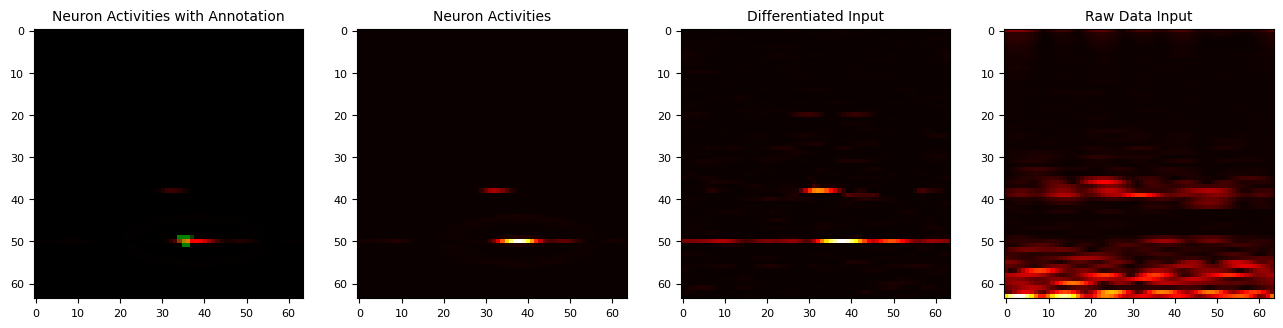

In [8]:

fig, (ax1, ax2, ax3, ax4)= plt.subplots(1, 4, figsize=(16,4), dpi=100)
rgb_img= np.zeros((64,64,3))
rgb_img[:,:,0] = neuron_act[100]
dense_, sparse_, box_ = get_annotations()
rgb_img[:,:,1] = dense_[100]

ax1.tick_params(axis='both',labelsize=8)
ax1.set_title("Neuron Activities with Annotation",fontsize=10)
ax2.tick_params(axis='both',labelsize=8)
ax2.set_title("Neuron Activities",fontsize=10)
ax3.tick_params(axis='both',labelsize=8)
ax3.set_title("Differentiated Input",fontsize=10)
ax4.tick_params(axis='both',labelsize=8)
ax4.set_title("Raw Data Input",fontsize=10)

cell_act_map_w_annot = ax1.imshow(rgb_img, cmap='hot', interpolation='none')
cell_act_map = ax2.imshow(np.array(neuron_act[100]), cmap='hot', interpolation='none')
input_diff_map = ax3.imshow(np.array(data_diff_normalized[100]), cmap='hot', interpolation='none')
input_map = ax4.imshow(np.array(data[100]), cmap='hot', interpolation='none')

plt.show()


MovieWriter ffmpeg unavailable; using Pillow instead.


IndexError: index 169 is out of bounds for axis 0 with size 169

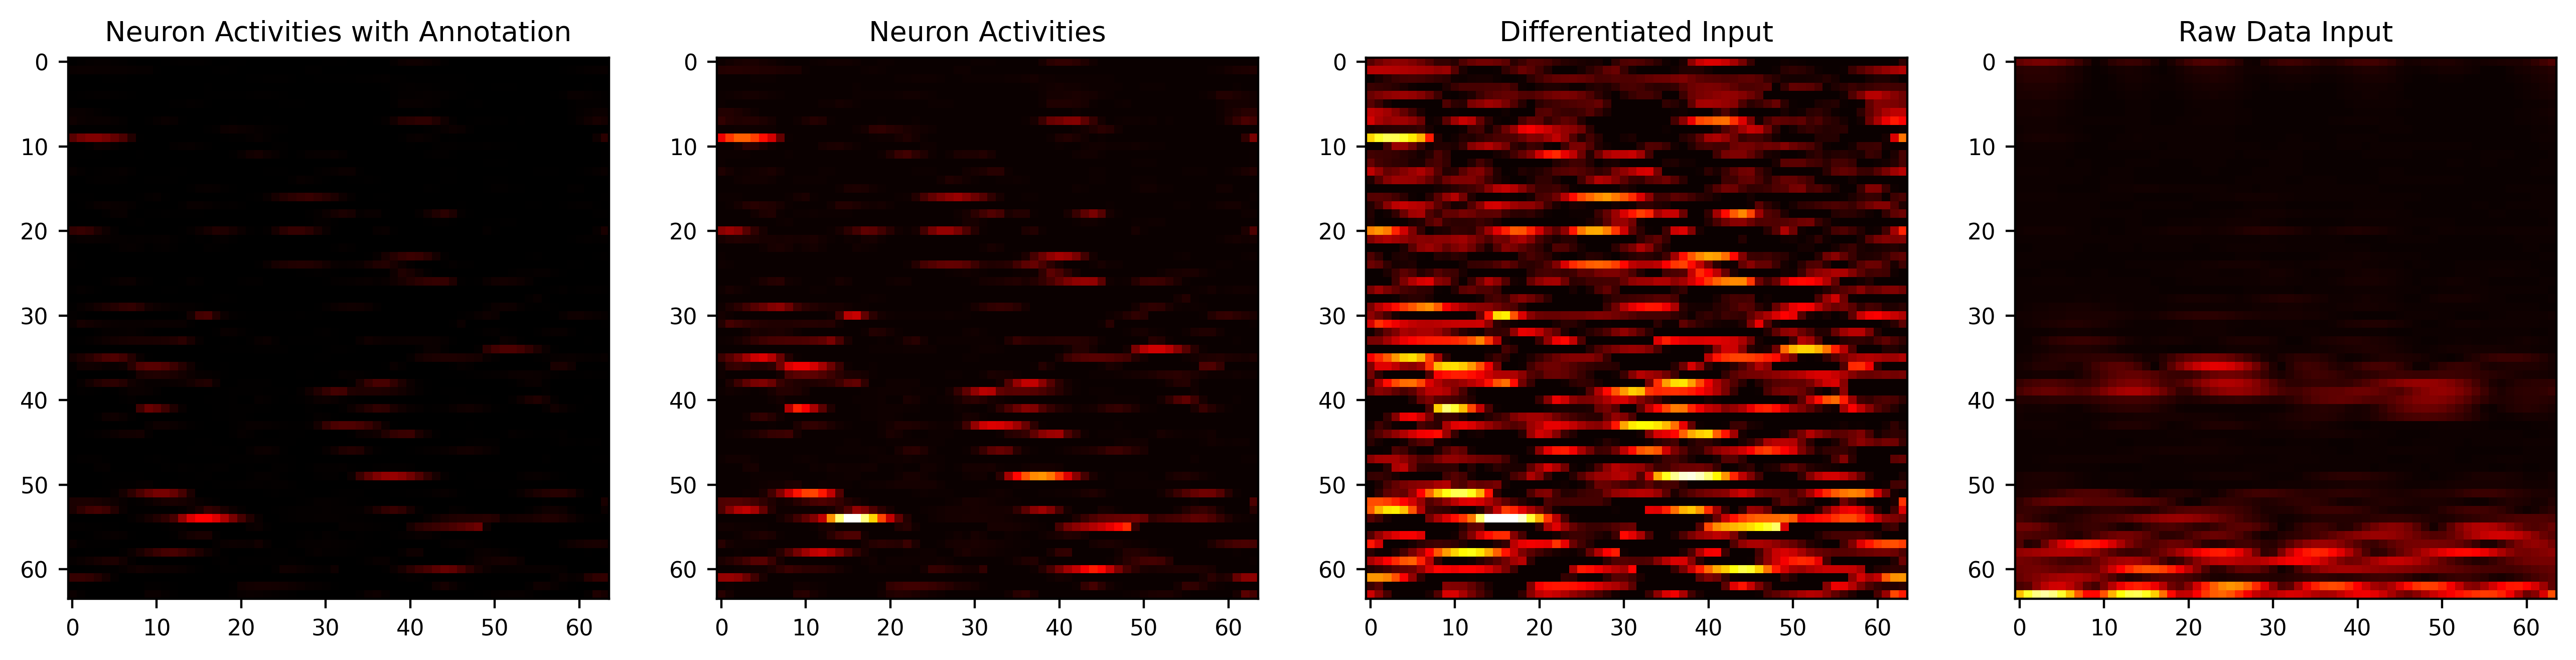

In [11]:
dense_, sparse_, box_ = get_annotations(differentiated=True)

fig, (ax1, ax2, ax3, ax4)= plt.subplots(1, 4, figsize=(16,4), dpi=400)

annotated_neuron_act = np.zeros((len(neuron_act), 64,64,3))
annotated_neuron_act[:,:,:,0] = neuron_act
annotated_neuron_act[:,:,:,1] = dense_

ax1.tick_params(axis='both',labelsize=8)
ax1.set_title("Neuron Activities with Annotation",fontsize=10)
ax2.tick_params(axis='both',labelsize=8)
ax2.set_title("Neuron Activities",fontsize=10)
ax3.tick_params(axis='both',labelsize=8)
ax3.set_title("Differentiated Input",fontsize=10)
ax4.tick_params(axis='both',labelsize=8)
ax4.set_title("Raw Data Input",fontsize=10)

cell_act_map_w_annot = ax1.imshow(annotated_neuron_act[0], cmap='hot', interpolation='none')
cell_act_map = ax2.imshow(np.array(neuron_act[0]), cmap='hot', interpolation='none')
input_diff_map = ax3.imshow(np.array(data_diff_normalized[0]), cmap='hot',interpolation='none')
input_map = ax4.imshow(np.array(data[1]), cmap='hot', interpolation='none')


def init():
    
    cell_act_map_w_annot.set_data(annotated_neuron_act[0])
    cell_act_map.set_data(np.array(neuron_act[0]))
    input_diff_map.set_data(np.array(data_diff_normalized[0]))
    input_map.set_data(np.array(data[1]))
    return [cell_act_map_w_annot, cell_act_map, input_diff_map, input_map]

# animation function.  This is called sequentially
def animate(i):
    cell_act_map_w_annot.set_data(annotated_neuron_act[i])
#     arr = neuron_act[i]/np.max(neuron_act[i])
#     arr[arr < 0.4] = 0
    cell_act_map.set_data(np.array((neuron_act[i])))
    input_diff_map.set_data(np.array(data_diff_normalized[i]))
    input_map.set_data(np.array(data[i+1]))
    return [cell_act_map_w_annot, cell_act_map, input_diff_map, input_map]


anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=200, interval=1, blit=True)

anim.save('animations/sample_anim3.gif', fps=10)


#fig.colorbar(cell_dists_map)

#plt.show()